#Sentiment Model Comparison on Airline Reviews for British Airways

##Executive Summary

This analysis compares the performance of three sentiment analysis models — **VADER**, **TextBlob**, and a **DistilBERT Transformer model** — on a sample of 100 reviews. A random sample of reviews was manually labeled as **positive, negative, or neutral** to establish a ground truth. Each model’s output was resolved into the same three sentiment categories to allow direct comparison.

### Model Accuracy Results

- **Transformer:** 69%
- **VADER:** 58%
- **TextBlob:** 35%

The Transformer model had the highest performance showing a stronger understanding of text context for long and nuanced airline reviews. VADER didn't have the worst performance but specifically struggled with the detection of netural reviews. TexBlob had the weakest performance and this is likely due to the high reliance on a simple polarity score without contextual understanding.

Overall, the deep learning models perform better than the lexicon based models for analyzing complex customer reviews.

The dataset used was obtained from Kaggle: https://www.kaggle.com/datasets/chaudharyanshul/airline-reviews
It contains customer feedback for British Airways extracted through web scraping from AirlineQuality.




##Step 1: Obtain Data

In [ ]:
#Import the necessary packages
import pandas as pd
pd.set_option('display.max_colwidth', None)
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from bs4 import BeautifulSoup


In [ ]:
#Extracting the data from github to allow for universal access
url = "https://raw.githubusercontent.com/marcelalozano27-ship-it/text-analytics-spring-2026/main/BA_AirlineReviews.csv"
df = pd.read_csv(url)
df.head()

,Unnamed: 0,OverallRating,ReviewHeader,Name,Datetime,VerifiedReview,ReviewBody,TypeOfTraveller,SeatType,Route,DateFlown,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity
0,0,1.0,"""Service level far worse then Ryanair""",L Keele,19th November 2023,True,"4 Hours before takeoff we received a Mail stating a cryptic message that there are disruptions to be expected as there is a limit on how many planes can leave at the same time. So did the capacity of the Heathrow Airport really hit British Airways by surprise, 4h before departure? Anyhow - we took the one hour delay so what - but then we have been forced to check in our Hand luggage. I travel only with hand luggage to avoid waiting for the ultra slow processing of the checked in luggage. Overall 2h later at home than planed, with really no reason, just due to incompetent people. Service level far worse then Ryanair and triple the price. Really never again. Thanks for nothing.",Couple Leisure,Economy Class,London to Stuttgart,November 2023,1.0,1.0,1.0,1.0,no,NaN,NaN,NaN,NaN
1,1,3.0,"""do not upgrade members based on status""",Austin Jones,19th November 2023,True,"I recently had a delay on British Airways from BRU to LHR that was due to staff shortages. They announced that there was a 2 hour holding delay but they would board us immediately in hopes of clearing the gate and leaving early. We had to wait the full 2 hours inside the airplane. The plane was old, dirty, had no power at the seats. The staff provided a small bag of pretzels and 250ml of water to the passengers for 2 hour delay and 2 hour flight. There were no options to purchase food or drink. There were no entertainment options available. I am a OneWorld emerald elite member but they do not upgrade members based on status. First class lounges at Heathrow are overcrowded, understaffed and poorly equipped. The help desk is completely unhelpful when an error arises with delays and cancellations - even when having the top status. The Avios points system has been devalued to near worthlessness and requires fees to book reward that nearly equal the price of the revenue ticket. British has lost its way in recent years and has a moved from a world-class airline to a budget airline with much worse service and timeliness than Ryanair or EasyJet.",Business,Economy Class,Brussels to London,November 2023,2.0,3.0,1.0,2.0,no,A320,1.0,2.0,2.0
2,2,8.0,"""Flight was smooth and quick""",M A Collie,16th November 2023,False,"Boarded on time, but it took ages to get to the runway due to congestion. Flight was smooth and quick. Snack and drinks were good for a short flight. Landed only about ten minutes late. One bag of three left in London, forms quickly filled in, and the bag was delivered the next morning.",Couple Leisure,Business Class,London Heathrow to Dublin,November 2023,3.0,3.0,4.0,3.0,yes,A320,4.0,NaN,NaN
3,3,1.0,"""Absolutely hopeless airline""",Nigel Dean,16th November 2023,True,"5 days before the flight, we were advised by BA that it had been cancelled and asked us to rebook. There were flights 1 hour before and 1 hour after our original flight but they made us take one 3 hours earlier. Our original ticket (and the return flight a week later) included a checked bag. When we arrive at Heathrow to check in we are told our ticket doesn't included a bag and we will have to pay 75 pounds each to take them. We explained that the original ticket had the bags and when they checked the system they confirmed that it did- but not this one! They would make no effort to sort it out and just told us to pay up or they would remove us from the flight. So we had no choice but to pay up, thinking it should be pretty easy to get a refund. 15 months and 10 emails later we have still not seen a penny. Every time I ask where my refund is and state how long we have been waiting I get an inane email saying some departments take longer than others to respond! Absolutely

##Step 2: Explore the Data


In [ ]:
df.describe()

,Unnamed: 0,OverallRating,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Food&Beverages,InflightEntertainment,Wifi&Connectivity,compound
count,3701.000000,3696.000000,3585.000000,3574.000000,2855.000000,3700.000000,3315.000000,2551.000000,609.000000,3701.000000
mean,1850.000000,4.734307,2.875314,3.254057,2.784238,2.688378,2.713122,2.646021,1.924466,0.168387
std,1068.531001,3.175306,1.362081,1.489709,1.457058,1.471887,1.437092,1.398509,1.352705,0.776612
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.997400
25%,925.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.723500
50%,1850.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,0.482500
75%,2775.000000,8.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,3.000000,0.928600
max,3700.000000,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.999200


In [ ]:
df.dtypes

,0
Unnamed: 0,int64
OverallRating,float64
ReviewHeader,object
Name,object
Datetime,object
VerifiedReview,bool
ReviewBody,object
TypeOfTraveller,object
SeatType,object
Route,object


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3701 entries, 0 to 3700
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             3701 non-null   int64  
 1   OverallRating          3696 non-null   float64
 2   ReviewHeader           3701 non-null   object 
 3   Name                   3701 non-null   object 
 4   Datetime               3701 non-null   object 
 5   VerifiedReview         3701 non-null   bool   
 6   ReviewBody             3701 non-null   object 
 7   TypeOfTraveller        2930 non-null   object 
 8   SeatType               3699 non-null   object 
 9   Route                  2926 non-null   object 
 10  DateFlown              2923 non-null   object 
 11  SeatComfort            3585 non-null   float64
 12  CabinStaffService      3574 non-null   float64
 13  GroundService          2855 non-null   float64
 14  ValueForMoney          3700 non-null   float64
 15  Reco

In [ ]:
print("The data set contains the following columns:\n", df.columns)
print(df.index)

The data set contains the following columns:
 Index(['Unnamed: 0', 'OverallRating', 'ReviewHeader', 'Name', 'Datetime',
       'VerifiedReview', 'ReviewBody', 'TypeOfTraveller', 'SeatType', 'Route',
       'DateFlown', 'SeatComfort', 'CabinStaffService', 'GroundService',
       'ValueForMoney', 'Recommended', 'Aircraft', 'Food&Beverages',
       'InflightEntertainment', 'Wifi&Connectivity'],
      dtype='object')
RangeIndex(start=0, stop=3701, step=1)


In [ ]:
missing=df.isna().sum().sort_values(ascending=False)
missing_pct=(missing/len(df)*100).round(2)
print("Percentage of missing values in each column:\n", missing_pct[missing_pct>0])

Percentage of missing values in each column:
 Wifi&Connectivity        83.54
Aircraft                 48.07
InflightEntertainment    31.07
GroundService            22.86
DateFlown                21.02
Route                    20.94
TypeOfTraveller          20.83
Food&Beverages           10.43
CabinStaffService         3.43
SeatComfort               3.13
OverallRating             0.14
SeatType                  0.05
ValueForMoney             0.03
dtype: float64


In [ ]:
#Determine the length
text=df["ReviewBody"].astype("string")

text=text.fillna("")

lengths=text.map(len)

minlength=int(lengths.min())
maxlength=int(lengths.max())
meanlength=float(lengths.mean())
medianlength=float(lengths.median())

print(f"Statistics of Review Text Length: \n Minimum Length: {minlength}\n Maximum Length: {maxlength}\n Mean Length: {meanlength}\n Median Length: {medianlength}")

Statistics of Review Text Length: 
 Minimum Length: 83
 Maximum Length: 3529
 Mean Length: 881.2842475006755
 Median Length: 736.0


In [ ]:
#Show sample text
for review in text.sample(10, random_state=1):
  print(review[:150])

Port of Spain to Gatwick via St. Lucia was a good experience. I don't have any complaints regarding the seat quality or flight attendants, who did a v
Delayed just for a change. Poor communication. British Airways sells premium prices flight tickets and delivers no better than a low cost airline. Cus
Flew Belfast to London with British Airways. Stressful day started with a 2.5 hours delay for the morning flight at 7am. As an apology, they sold us t
Sydney to London via Singapore. It has been a very long time since I was on a long haul with BA of more than 9 hours. Last year had a relative sprint 
Istanbul to London Heathrow. I am a frequent flyer between Turkey and Canada. I got first time flight by British Airways. I feel it was the worst airl
London to Vancouver. Check in agent very helpful in searching out seat options. Very smooth process. The disappointment was the receptionist at the Ga
Our Good Friday flight was delayed by 5hours, STD 12.50 ATD 18.00 TO Durban, South Africa from

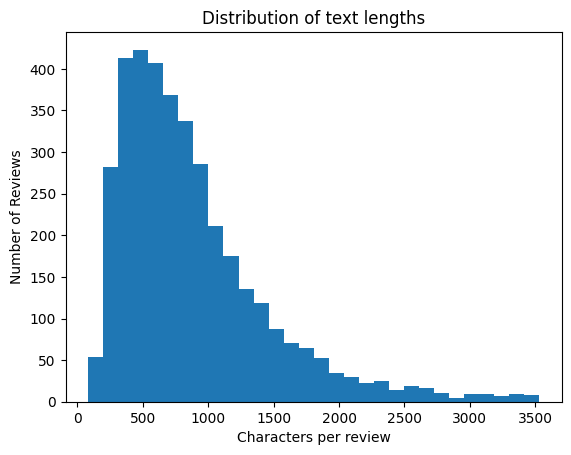

In [ ]:
plt.hist(lengths, bins=30)
plt.title("Distribution of text lengths")
plt.xlabel("Characters per review")
plt.ylabel("Number of Reviews")
plt.show()

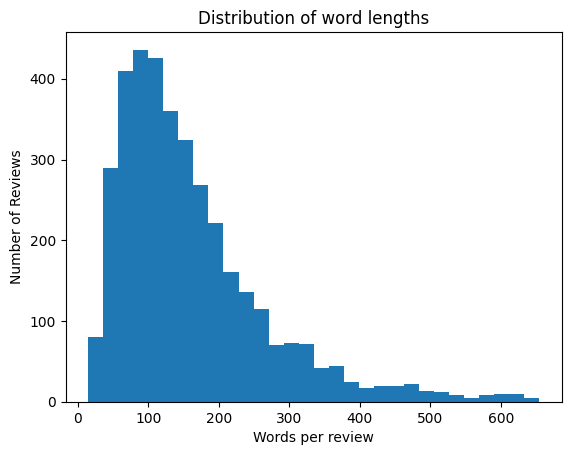

In [ ]:
wordcounts=text.str.split().str.len()
plt.hist(wordcounts, bins=30)
plt.title("Distribution of word lengths")
plt.xlabel("Words per review")
plt.ylabel("Number of Reviews")
plt.show()

####Distribution of Review Text Lengths
A histogram was used to visualize word lengths as well as the number of characters per review. The distribution is right skewed meaning most users write shorter reviews with a small number being longer. The longer reviews could potentially provide richer sentiment and contextual information.

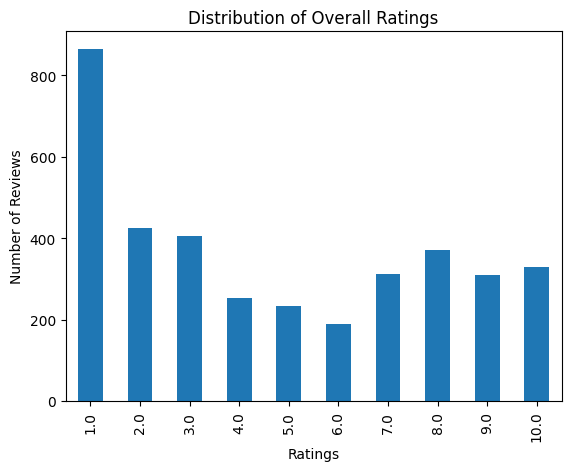

In [ ]:
df['OverallRating'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Overall Ratings")
plt.xlabel("Ratings")
plt.ylabel("Number of Reviews")
plt.show()

###Distribution of Overall Ratings
The rating disribution shows a high concentration of lower rating categories. There is potential class imbalance and sentiment bias which may impact our model performance given the model will be trained to predict negative sentiment more often.

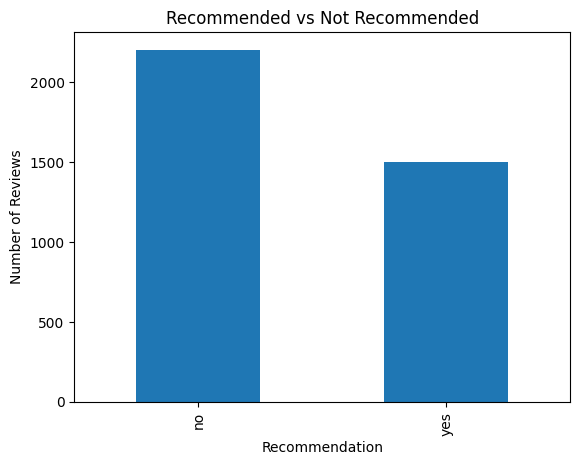

In [ ]:
df['Recommended'].value_counts().plot(kind='bar')
p=plt.title("Recommended vs Not Recommended")
plt.xlabel("Recommendation")
plt.ylabel("Number of Reviews")
plt.show()

###Recommended vs Not Recommended
A bar chart was used to visualize the distribution of recommended vs not recommended. There seem to be more negative experiences which further contributes to class imbalance of recommendation related analyses.

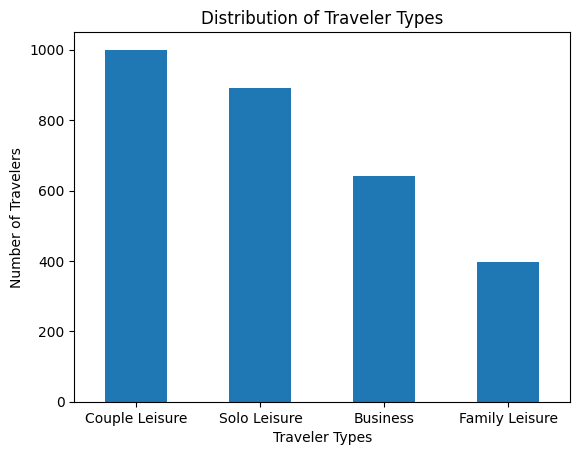

In [ ]:
df['TypeOfTraveller'].value_counts().plot(kind='bar')
p=plt.title("Distribution of Traveler Types")
plt.xlabel("Traveler Types")
plt.ylabel("Number of Travelers")
plt.xticks(rotation=0)
plt.show()

###Distribution of Traveler Types

The data contains four traveler types but is slightly imbalanced when it comes to traveler types with more leisure travelers, especially solo and couple leisure travlers.

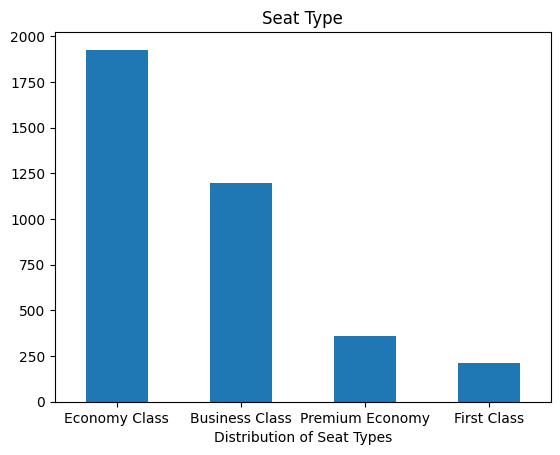

In [ ]:
df['SeatType'].value_counts().plot(kind='bar')
p=plt.title("Seat Type")
plt.xlabel("Distribution of Seat Types")
plt.xticks(rotation=0)
plt.show()

### Seat Type Distribution
The majority of the reviews in the dataset come from Economy class passengers. The dataset is imbalanced and heavily skewed toward economy travelers which may have an impact on overall sentiment and rating patterns. The Economy class dominates the dataset and might cause bias since the expectations of the consumer differ for each class.

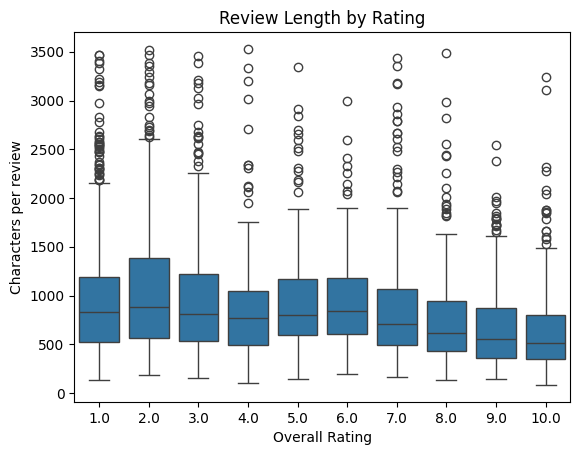

In [ ]:
sns.boxplot(x=df['OverallRating'], y=lengths)
plt.title("Review Length by Rating")
plt.xlabel("Overall Rating")
plt.ylabel("Characters per review")
plt.show()


###Review Length by Rating

The boxplot visualization shows that lower ratings between 1-3 tend to have longer review lengths as well as more variability in lengths compared to those reviews with higher ratings.This is likely because unsatisfied customers are more likely to write lengthly descriptions of negative experiences. All of the ratings have outliers present but the median length seems to decrease as the ratings get higher.

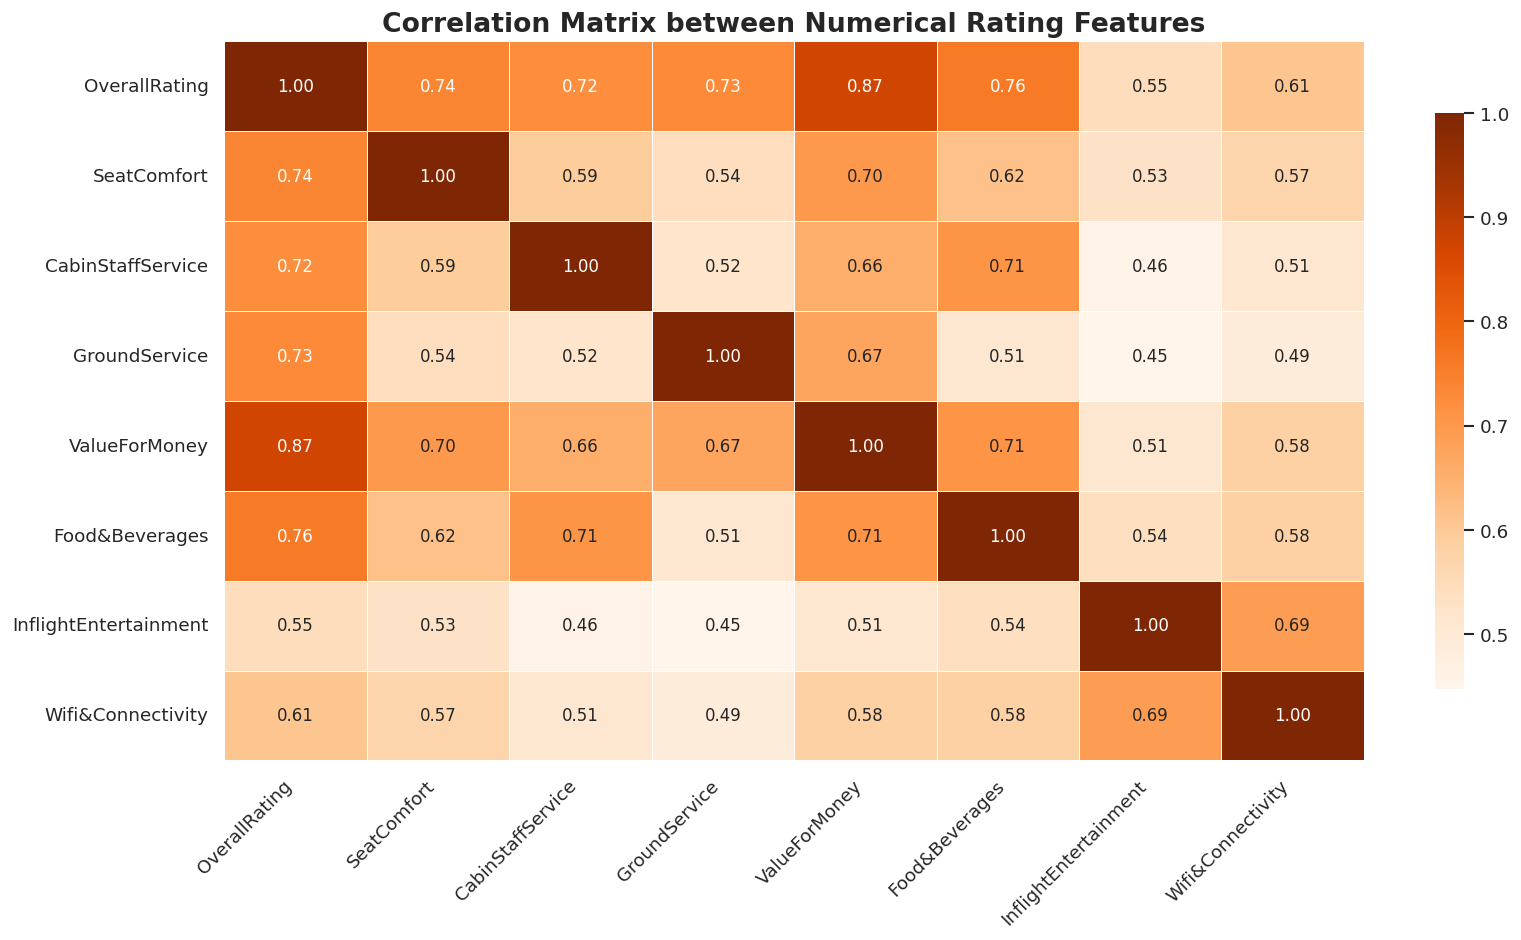

In [ ]:
numeric_cols = ["OverallRating", "SeatComfort", "CabinStaffService", "GroundService",
                "ValueForMoney", "Food&Beverages", "InflightEntertainment", "Wifi&Connectivity"]

df_num = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
corr = df_num.corr()

plt.figure(figsize=(14, 8), dpi=120)
sns.heatmap(corr, annot=True, cmap="Oranges", fmt=".2f",
            linewidths=0.5, cbar_kws={"shrink": 0.8}, annot_kws={"size": 10})
plt.title("Correlation Matrix between Numerical Rating Features", fontsize=16, weight="bold")
plt.xticks(rotation=45, ha="right", fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()


###Correlation Matrix between Numerical Rating Features
We can see strong positive correlations between Overall rating and service related features like the value for money or food and beverages. Passengers' overall satisfaction seems to be heavily influenced by their perceived value and in flight experience factors.

From our initial analysis of the data, the reviews are written in English and in full sentences. I used a random sample of 400 reviews to get a better idea of the amount of reviews with special characters, URLs, hashtags or HTML tags and found none.

There are also no noted formatting problems and it will be enough to just perform some minor cleaning like lowercasing, removing punctuation and trimming white space.

The main pattern noticed is that reviews are long narratives.

##Step 3: Text Cleaning and Preprocessing

In [ ]:
import re

# Simple contraction dictionary
contractions = {
    "don't": "do not",
    "can't": "cannot",
    "won't": "will not",
    "i'm": "i am",
    "it's": "it is",
    "that's": "that is",
    "didn't": "did not",
    "doesn't": "does not",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not"
}

def clean_text(t):
    t = str(t)

    # remove HTML tags
    t = re.sub(r"<.*?>", " ", t)

    # remove URLs
    t = re.sub(r"http\S+|www\S+", " ", t)

    # lowercase
    t = t.lower()

    # expand contractions
    for c in contractions:
        t = t.replace(c, contractions[c])

    # remove numbers
    t = re.sub(r"\d+", " ", t)

    # remove extra whitespace
    t = re.sub(r"\s+", " ", t).strip()

    return t

df["clean_text"] = df["ReviewBody"].apply(clean_text)
examples = df[["ReviewBody", "clean_text"]].sample(3)

for raw, cleaned in zip(examples["ReviewBody"], examples["clean_text"]):
    print("\n==============================")
    print("Before:")
    print(str(raw)[:300])

    print("\nAfter:")
    print(str(cleaned)[:300])

    print("\nWhy this matters:")
    print("Removed HTML, URLs, special characters, lowercased, and cleaned whitespace.")



Before:
An interesting contrast on recent Gatwick to Turin and back flights. Going out it was a (new?) A320 which was bright clean and spacious. On the way back it was a B737 which was clean but a bit tatty and felt cramped. Service food and drinks on both flights was commendable. I believe that all of BA's

After:
an interesting contrast on recent gatwick to turin and back flights. going out it was a (new?) a which was bright clean and spacious. on the way back it was a b which was clean but a bit tatty and felt cramped. service food and drinks on both flights was commendable. i believe that all of ba's s ret

Why this matters:
Removed HTML, URLs, special characters, lowercased, and cleaned whitespace.

Before:
Busy day at LHR and flight full. Lounge crowded but B gates lounge quieter. Flight left on time, very professional crew, greeted by name and executive club status acknowledged and thanked for return custom. A nice touch. Service was good. Food average. Entertainment good. Earl

You can refresh the text a few times to confirm that even when generating a new random three examples, they all are being cleaned in a consistent way.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


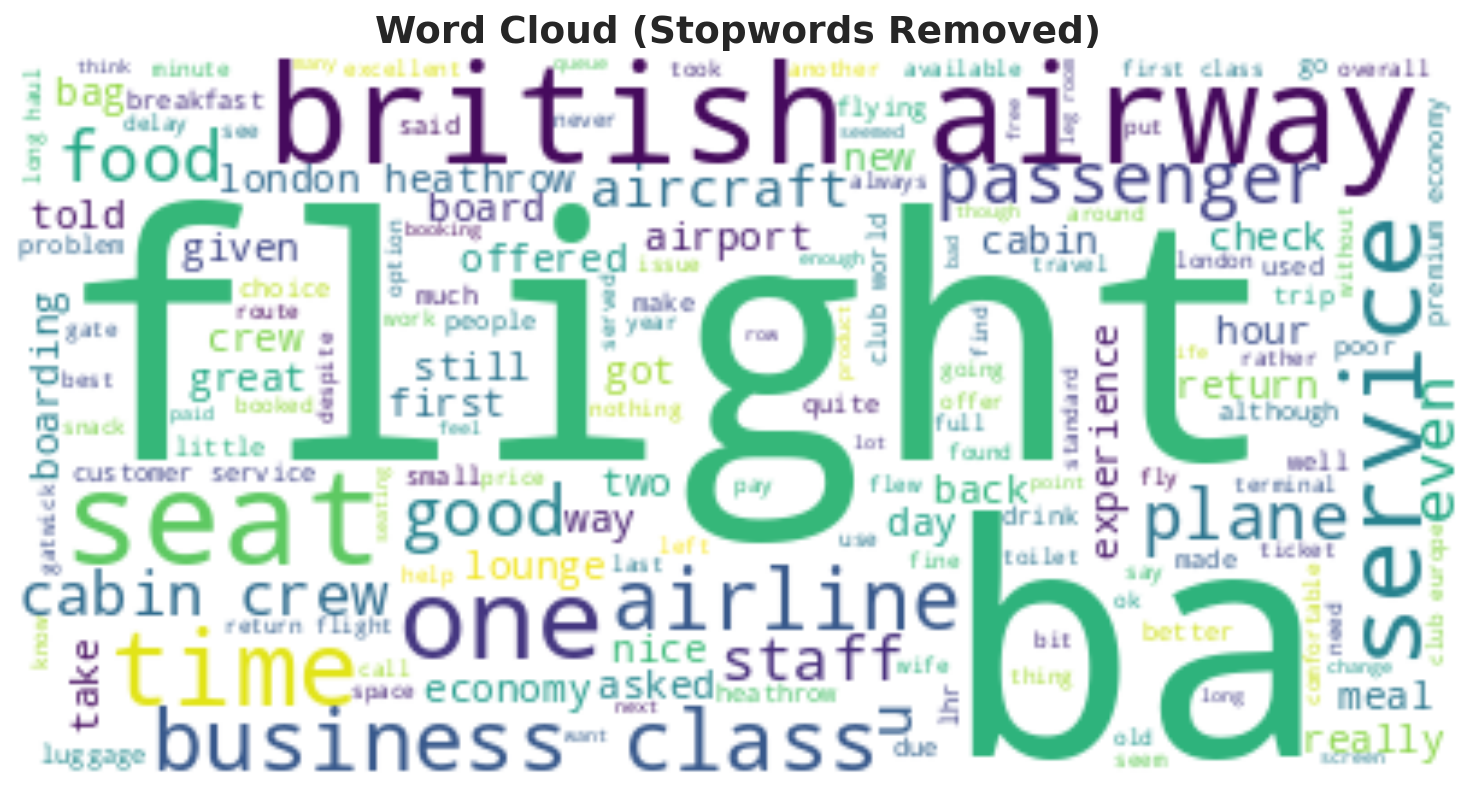

In [ ]:
import nltk
import nltk
nltk.download( 'punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# Base stop words
stop_words = set(stopwords.words('english'))

# Custom airline stop words
custom_stopwords = {
    "https", "http", "co", "www", "rt", "RT",
    "aren", "couldn", "didn", "doesn", "don", "hadn", "hasn", "haven",
    "isn", "let", "ll", "mustn", "re", "shan", "shouldn", "ve", "wasn",
    "weren", "won", "wouldn"
}

stop_words = stop_words.union(custom_stopwords)

# Function to remove stop words
def remove_stopwords(text):
    text = str(text).lower()
    words = word_tokenize(text)
    filtered_words = [
    word for word in words
    if word.isalpha() and word not in stop_words
]

    return " ".join(filtered_words)

# Apply cleaning
df["cleaned_review"] = df["clean_text"].apply(remove_stopwords)

# Preview
print(df[["clean_text", "cleaned_review"]].head())

from wordcloud import WordCloud
from wordcloud import STOPWORDS
full_text = " ".join(df["cleaned_review"].fillna("").astype(str))
cloud_no_stopword = WordCloud(background_color="white").generate(full_text)

plt.figure(figsize=(10, 6), dpi=150)

plt.imshow(cloud_no_stopword, interpolation='bilinear')
plt.axis('off')

plt.title(
    "Word Cloud (Stopwords Removed)",
    fontsize=18,
    weight="bold"
)

plt.tight_layout()
plt.show()


###Stop Word Removal and text cleaning were done only for exploratory purposes and the models used the original raw text.

##Step 4: Tokenize, Feature Engineer, and Vectorize / Step 5: Apply Pretrained Models

In [ ]:
!pip -q install transformers torch

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "bhadresh-savani/distilbert-base-uncased-emotion"
)

# Take one example review
example_text = df["ReviewBody"].fillna("").iloc[0]

# Tokenize it
encoded = tokenizer(
    example_text,
    truncation=True,
    padding=True,
    return_tensors="pt"
)

print("Token IDs:", encoded["input_ids"][0][:20])
print("Attention mask:", encoded["attention_mask"][0][:20])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Token IDs: tensor([  101,  1018,  2847,  2077, 19744,  2057,  2363,  1037,  5653,  5517,
         1037, 26483,  4471,  2008,  2045,  2024, 20461,  2015,  2000,  2022])
Attention mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


### Data Preparation

Model specific preprocessing steps were applied based on the requirements of each sentiment model.

- VADER and Transformer:These models require only light preprocessing(removal of HTML tags, URLs, and normalization of whitespace). VADER is designed to handle punctuation and capitalization, while the transformer model uses its own tokenizer, so excessive cleaning may reduce performance.

- TextBlob: TextBlob uses rule-based polarity scoring and benefits from standardized input. Therefore, the text was lowercased in addition to basic cleaning (removal of HTML, URLs, and extra spaces). The preprocessed `clean_text` column was used to ensure consistent polarity calculation.


In [ ]:
def vader_prep(t):
    t = str(t)
    t = re.sub(r"<.*?>", " ", t)             # remove HTML
    t = re.sub(r"http\S+|www\S+", " ", t)    # remove URLs
    t = re.sub(r"\s+", " ", t).strip()       # normalize spaces

    return t

df["vader_text"] = df["ReviewBody"].fillna("").apply(vader_prep)

df["textblob_text"] = df["ReviewBody"].fillna("").apply(clean_text)

# Vader and the transformer can use similarly cleaned data
df['transformertext']=df['vader_text']

###Vader
VADER is a lexicon based sentiment model that relies on predefined word sentiment scores and punctuation emphasis. It produces four scores: positive, negative, neutral and a compound score which represents the normalized weighted sentiment score ranging from (-1,1).

This model works well for clearly emotional language but struggles with more neutral or nuanced phrasing.


In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:

if "OverallRating" in df.columns:
    airline_best_worst = df[
        (df["OverallRating"] == 10) |
        (df["OverallRating"] == 1)
    ].reset_index(drop=True)
else:
    airline_best_worst = df.copy()

print("\nBest/Worst sample size:", len(airline_best_worst))

examples = airline_best_worst.sample(3, random_state=1)

for text in examples["vader_text"]:
    print("\n==============================")
    print("Example review:")
    print(text[:500])
    print("\nVADER scores:")
    print(sid.polarity_scores(text))



Best/Worst sample size: 1195

Example review:
Couldn’t book in online. Arrived at check in to find we had been bumped off due to overselling. No BA staff available. Very helpful Gatwick staff got us a bus to LHR and a flight to Toulouse. Had knock in effect on our car booking and sharing as the rest of family had been able yo board original flight. Airlines should be legally stopped from selling seats twice.

VADER scores:
{'neg': 0.079, 'neu': 0.792, 'pos': 0.129, 'compound': 0.5709}

Example review:
Hong Kong to London. I booked a return ticket for my sister though BA, provided travel document details they required. However when we got to the airport we found out my sisters middle name was not on her ticket and it therefore didn't match her passport name. They refused to let her fly, after much hassle and my sister getting a temporary visa, they enable her to fly. However, once landing in London I acknowledged that she may have the same problem flying back to Taiwan. Igot in contact

In [ ]:
print("Examples of Reviews likely to be Positive:\n")
for review in df[df["OverallRating"] == 10]["ReviewBody"].head():
    print("-", review, "\n")

print("Examples of Reviews likely to be Negative:\n")
for review in df[df["OverallRating"] == 1]["ReviewBody"].head():
    print("-", review, "\n")


Examples of Reviews likely to be Positive:

- Excellent service levels, proactive crew and superb food and beverages. I found all aspects of the service to be superior to BA business class, even the new BA Club Suites. First Class felt exclusive, the dedicated crew were clearly used to working the premium cabin, enjoying their work, were proactive, friendly, very respectful and the food and beverage offering a considerable step up from business class. The seat, with sliding double doors was spacious, well designed and very comfortable.  British Airways offered a solid First Class service, from Concorde Lounge to boarding (which was actually by group number for a change) to the very warm and genuine welcome on boarding. A consistent, solid, comfortable service from start to finish and if the price was right, I would not hesitate to book First Class with British Airways again. 

- Good domestic flight operated by BA Cityflyer. Ground service at check-in Edinburgh airport was particularly

,Word,Sentiment Score
0,BA,0.0000
1,has,0.0000
2,a,0.0000
3,real,0.0000
4,problem,-0.4019
5,with,0.0000
6,boarding,0.0000
7,it's,0.0000
8,flights.,0.0000
9,Those,0.0000


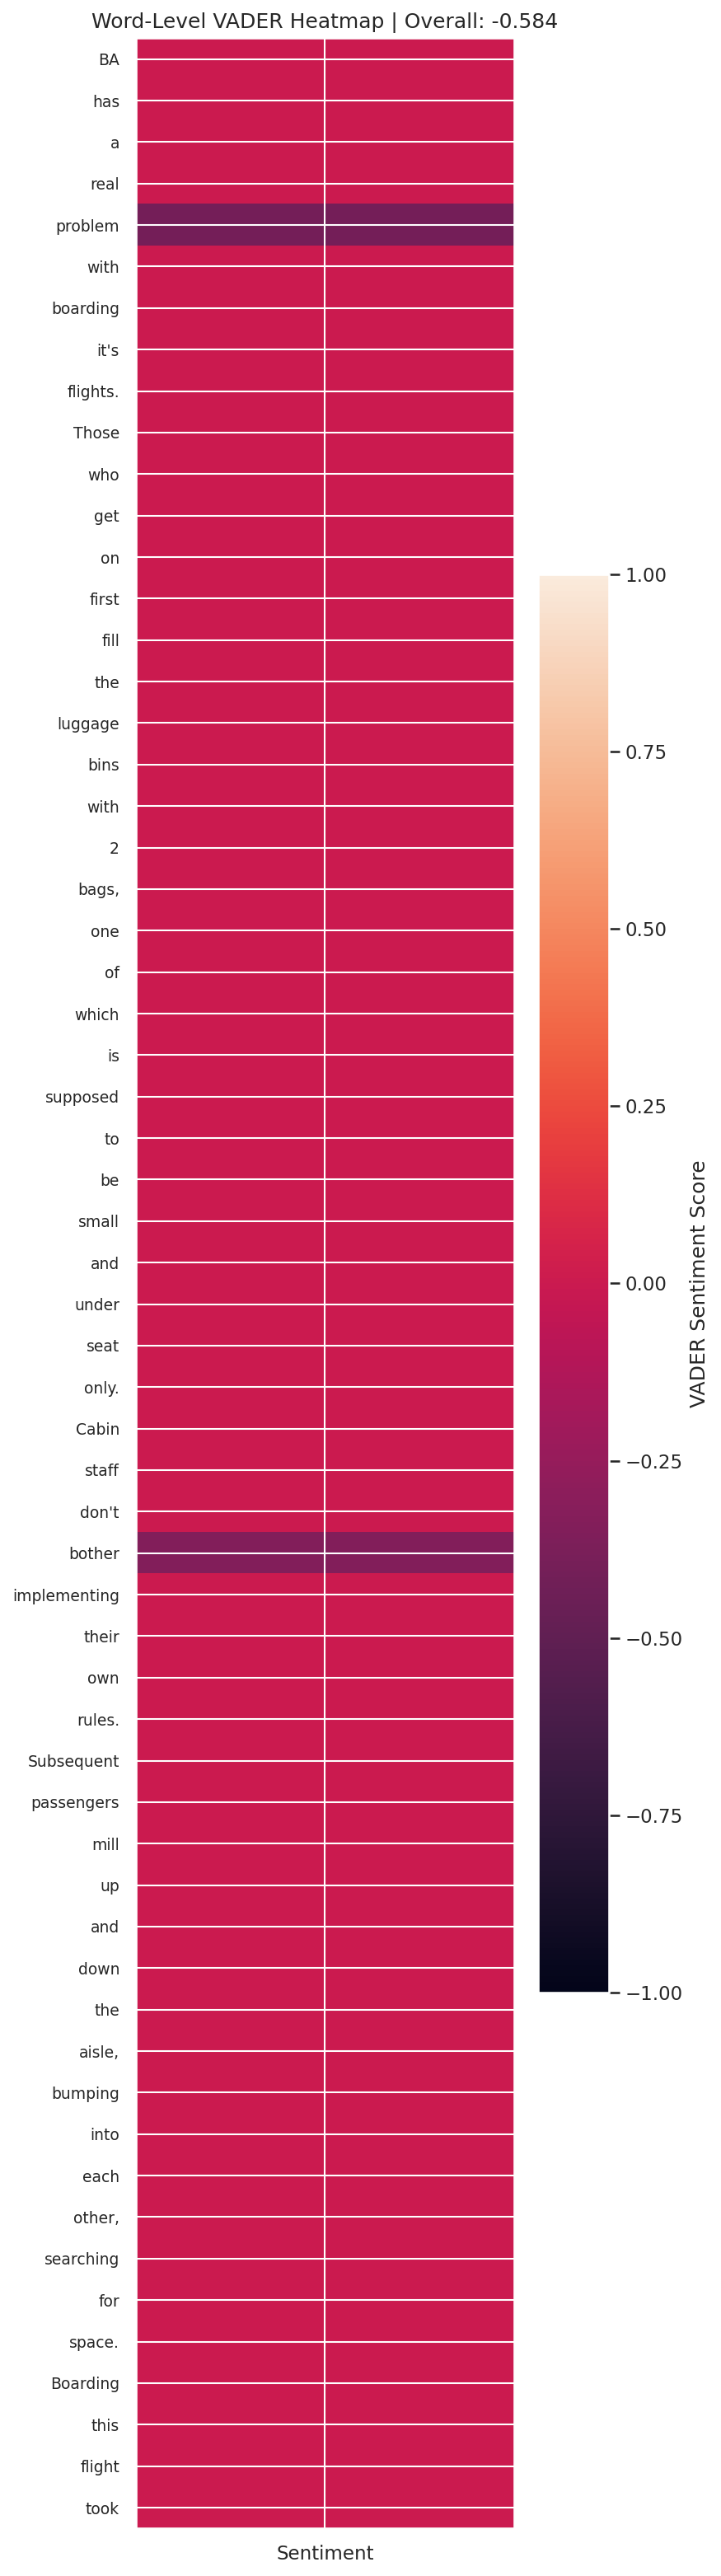

In [ ]:
def visualise_sentiments_heatmap(sentence, analyser, max_words=60):
    sentence = str(sentence)
    overall = analyser.polarity_scores(sentence)["compound"]
    words = sentence.split()[:max_words]
    scores = [analyser.polarity_scores(w)["compound"] for w in words]

    df_heat = pd.DataFrame({"Word": words, "Sentiment Score": scores})
    display(df_heat)

    heat_matrix = np.array(scores).reshape(-1, 1)
    plt.figure(figsize=(6, max(2, len(words) * 0.35)), dpi=150)
    plt.imshow(heat_matrix, aspect="auto", vmin=-1, vmax=1)
    plt.colorbar(label="VADER Sentiment Score")
    plt.yticks(range(len(words)), words, fontsize=9)
    plt.xticks([0], ["Sentiment"])
    plt.title(f"Word-Level VADER Heatmap | Overall: {overall:.3f}", fontsize=12)
    plt.tight_layout()
    plt.show()
example_text = airline_best_worst.iloc[12]["vader_text"]
visualise_sentiments_heatmap(example_text, sid, max_words=60)




In [ ]:
df['compound'] = df['ReviewBody'].apply(lambda x: sid.polarity_scores(str(x))['compound'])


###TextBlob

TextBlob is a lexicon based sentiment analysis that calculates sentiment using a polarity score from (-1,1). The polarity score is a representation of the overall emotional direction of the text.

This model relies heavily on word level sentiment averaging.

In [ ]:
from textblob import TextBlob
def detect_sentiment(text):

    #Convert text into a TextBlob object
    blob = TextBlob(text)

    return blob.sentiment.polarity

airline_best_worst.loc[31,"textblob_text"]

'british airways has a total lack of respect for its customers. i was booked to fly from frankfurt main to london city airport, and just a couple of hours before the scheduled departure the flight was suddenly cancelled by ba without explanation, when i was already at the airport. the worst thing was the utter callousness that staff showed towards customers. the ground staff’s attitude was that they are merely third party agents, not ba employees, and therefore they quickly washed their hands of us all, telling us we had to contact ba directly via phone if we wanted help. they couldn’t even provide us a phone number, telling us to look it up on ba.com ! so ba abandoned its passengers. they did tell us that the ba departure to heathrow had also been cancelled, meaning there would be no further ba flight from frankfurt to london that day (although other airlines were still operating the route- but ba refused to rebook us on them). the reason given for both cancellations was “technical re

In [ ]:
blob = TextBlob(airline_best_worst.loc[31,"textblob_text"])
print(blob)
print()
print(blob.sentiment)

british airways has a total lack of respect for its customers. i was booked to fly from frankfurt main to london city airport, and just a couple of hours before the scheduled departure the flight was suddenly cancelled by ba without explanation, when i was already at the airport. the worst thing was the utter callousness that staff showed towards customers. the ground staff’s attitude was that they are merely third party agents, not ba employees, and therefore they quickly washed their hands of us all, telling us we had to contact ba directly via phone if we wanted help. they couldn’t even provide us a phone number, telling us to look it up on ba.com ! so ba abandoned its passengers. they did tell us that the ba departure to heathrow had also been cancelled, meaning there would be no further ba flight from frankfurt to london that day (although other airlines were still operating the route- but ba refused to rebook us on them). the reason given for both cancellations was “technical rea

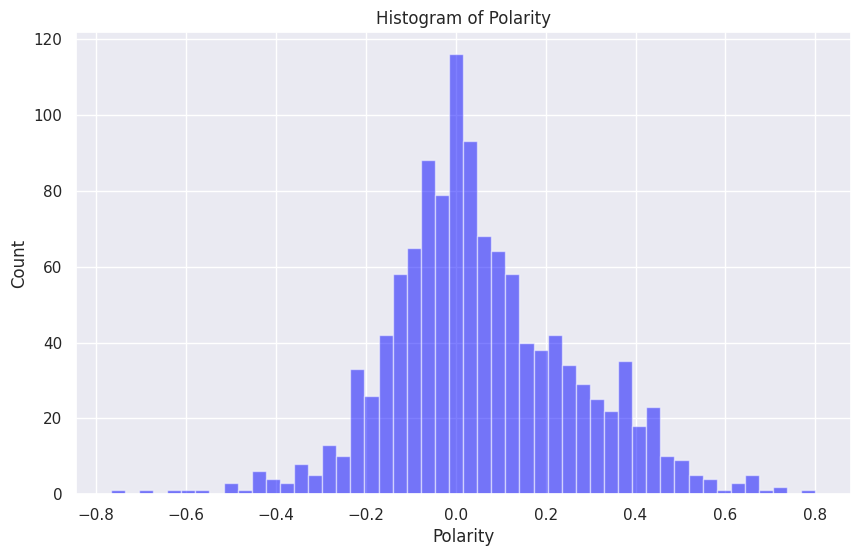

In [ ]:
airline_best_worst["polarity"] = airline_best_worst.textblob_text.apply(detect_sentiment)
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(airline_best_worst.polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of Polarity')
plt.show()

###Transformer Model (DistilBERT Emotion Model)
The pre trained DistilBERT transformer model is used for performing sentiment classification based on contextual understanding. The transformer analyzes the semantic meaning of the review text as a whole as opposed to using individual words. The model outputs the dominant emotion label.

This model is best for capturing tone and context.

In [ ]:
from transformers import pipeline
classifier = pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion')
prediction = classifier(airline_best_worst.loc[31,"transformertext"])

print(prediction)
print(airline_best_worst.loc[31,"ReviewBody"])

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

[{'label': 'anger', 'score': 0.9756035208702087}]
British Airways has a total lack of respect for its customers. I was booked to fly from Frankfurt Main to London City Airport, and just a couple of hours before the scheduled departure the flight was suddenly cancelled by BA without explanation, when I was already at the airport. The worst thing was the utter callousness that staff showed towards customers. The ground staff’s attitude was that they are merely third party agents, not BA employees, and therefore they quickly washed their hands of us all, telling us we had to contact BA directly via phone if we wanted help. They couldn’t even provide us a phone number, telling us to look it up on ba.com ! So BA abandoned its passengers. They did tell us that the BA departure to Heathrow had also been cancelled, meaning there would be no further BA flight from Frankfurt to London that day (although other airlines were still operating the route- but BA refused to rebook us on them). The reas

##Step 6: Analyze and Review Results

A random sample of 100 reviews was selected for consistency when comparing models. Each review was manually labeled as positive, negative, or neutral to establish a ground truth column in the dataset.

All model outputs were converted into the same three sentiment categories:

- **VADER:** Compound score threshold (≥ 0.05 positive, ≤ -0.05 negative)
- **TextBlob:** Polarity score threshold (> 0.1 positive, < -0.1 negative)
- **Transformer:** Highest probability emotion mapped to sentiment

In [ ]:
#I am keeping 100 random samples for consistency when comparing models
sample_100 = df.sample(100, random_state=1).copy().reset_index(drop=True)
sample_100.to_csv("sampleairlinereviews.csv", index=False)


In [ ]:
dataurl="https://raw.githubusercontent.com/marcelalozano27-ship-it/text-analytics-spring-2026/e6fe88be9bbe17fa85c7e6085fd18cda3c16aee7/sampleairlinereviews.csv"
sample_100 = pd.read_csv(dataurl)
sample_100 = sample_100.drop(columns=["Unnamed: 0"], errors="ignore")
# standardize labels
sample_100["ground_truth"] = sample_100["ground_truth"].astype(str).str.strip().str.lower()

print(sample_100["ground_truth"].unique())


['neutral' 'negative' 'positive']


####Label Thresholds
We will be setting thresholds to turn sentiment score/emotion category into a label(positive, negative, neutral) that can be compared to the ground truth.

In [ ]:
sample_100["vader_compound"]=sample_100["vader_text"].apply(lambda x: sid.polarity_scores(x)["compound"])
def vader_label(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

sample_100["vader_pred"] = sample_100["vader_compound"].apply(vader_label)


In [ ]:
sample_100["textblob_polarity"] = sample_100["textblob_text"].apply(
    lambda x: TextBlob(x).sentiment.polarity
)
def textblob_label(score):
    if score > 0.1:
        return "positive"
    elif score < -0.1:
        return "negative"
    else:
        return "neutral"

sample_100["textblob_pred"] = sample_100["textblob_polarity"].apply(textblob_label)


In [ ]:
sample_100["transformer_raw"] = sample_100["transformertext"].astype(str).apply(
    lambda x: classifier(x[:512])[0]["label"]
)

positive_emotions = {"joy", "love"}
negative_emotions = {"anger", "sadness", "fear"}
neutral_emotions = {"surprise"}

def transformer_label(emotion):
    if emotion in positive_emotions:
        return "positive"
    elif emotion in negative_emotions:
        return "negative"
    elif emotion in neutral_emotions:
        return "neutral"
    else:
        return "neutral"  # safety fallback


sample_100["transformer_pred"] = sample_100["transformer_raw"].apply(transformer_label)


In [ ]:
import time

# -------- SPEED COMPARISON (on the same 100 sample) --------

print("Running speed comparison on 100 sample reviews...\n")

start_vader = time.time()
_ = sample_100["vader_text"].astype(str).apply(
    lambda x: sid.polarity_scores(x)["compound"]
)
vader_time = time.time() - start_vader

start_textblob = time.time()
_ = sample_100["textblob_text"].astype(str).apply(
    lambda x: TextBlob(x).sentiment.polarity
)
textblob_time = time.time() - start_textblob

start_transformer = time.time()
_ = sample_100["transformertext"].astype(str).apply(
    lambda x: classifier(x, truncation=True, max_length=512)[0]["label"]
)
transformer_time = time.time() - start_transformer

# Print results
print("Speed Comparison (100 Reviews):")
print(f"VADER Time: {vader_time:.4f} seconds")
print(f"TextBlob Time: {textblob_time:.4f} seconds")
print(f"Transformer Time: {transformer_time:.4f} seconds")

# Create comparison table
speed_df = pd.DataFrame({
    "Model": ["VADER", "TextBlob", "Transformer"],
    "Execution Time (seconds)": [vader_time, textblob_time, transformer_time]
})

print("\nExecution Time Summary:")
print(speed_df)


Running speed comparison on 100 sample reviews...

Speed Comparison (100 Reviews):
VADER Time: 0.1497 seconds
TextBlob Time: 0.0976 seconds
Transformer Time: 35.5034 seconds

Execution Time Summary:
         Model  Execution Time (seconds)
0        VADER                  0.149719
1     TextBlob                  0.097626
2  Transformer                 35.503441


###Model Speed Comparison Analysis

Execution time was measured for each of the models using the same sample of 100 reviews to ensure consistency.

VADER is the fastest model only taking about.15 seconds given the lexicon approach which does not require heavy computation. Text Blob took longer than VADER because it requires more text processing.

The Transformer model took the longest because it relies more on deep learning and contextual embeddings. While the cost of the transformer model might be higher, it provides more context aware sentiment predictions.

###Model Predictions are compared to the ground truth labels using accuracy, precision,recall and F1 score.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_true = sample_100["ground_truth"]

print("VADER Accuracy:", accuracy_score(y_true, sample_100["vader_pred"]))
print("TextBlob Accuracy:", accuracy_score(y_true, sample_100["textblob_pred"]))
print("Transformer Accuracy:", accuracy_score(y_true, sample_100["transformer_pred"]))

print("\nVADER Report:\n", classification_report(y_true, sample_100["vader_pred"]))
print("\nTextBlob Report:\n", classification_report(y_true, sample_100["textblob_pred"]))
print("\nTransformer Report:\n", classification_report(y_true, sample_100["transformer_pred"]))

VADER Accuracy: 0.58
TextBlob Accuracy: 0.35
Transformer Accuracy: 0.69

VADER Report:
               precision    recall  f1-score   support

    negative       0.94      0.56      0.70        59
     neutral       0.00      0.00      0.00        15
    positive       0.38      0.96      0.55        26

    accuracy                           0.58       100
   macro avg       0.44      0.51      0.42       100
weighted avg       0.66      0.58      0.56       100


TextBlob Report:
               precision    recall  f1-score   support

    negative       0.90      0.15      0.26        59
     neutral       0.09      0.27      0.14        15
    positive       0.47      0.85      0.60        26

    accuracy                           0.35       100
   macro avg       0.49      0.42      0.33       100
weighted avg       0.67      0.35      0.33       100


Transformer Report:
               precision    recall  f1-score   support

    negative       0.87      0.76      0.81        59


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##Examples of Model Failures and Successes

### VADER Success Analysis



In [ ]:
vader_success = sample_100[
    sample_100["ground_truth"] == sample_100["vader_pred"]
]

vader_failure = sample_100[
    sample_100["ground_truth"] != sample_100["vader_pred"]
]

print("Three examples where VADER SUCCEEDED:")
for i, row in vader_success.sample(3, random_state=1).iterrows():
    print("-------------------------------")
    print("Text:", row["ReviewBody"])
    print("Actual:", row["ground_truth"])
    print("Predicted:", row["vader_pred"])
    print("Compound Score:", row["vader_compound"])



Three examples where VADER SUCCEEDED:
-------------------------------
Text: London to Seville. Following on from mistakenly booking a return flight with BA despite having a previous confirmed booking with a competitor, I quickly called up BA to resolve the issue. They understood the problem and gave me a full refund. The agent was exceptionally helpful on the phone and provided me a quick answer and solution to the problem. I don’t believe most airlines would have accepted my reasoning, however it’s great to see BA treat their customers with care.
Actual: positive
Predicted: positive
Compound Score: 0.9099
-------------------------------
Text: Istanbul to London Heathrow. I am a frequent flyer between Turkey and Canada. I got first time flight by British Airways. I feel it was the worst airline so far compared to others. Can you imagine that they even did not give a cup of water to the passengers for 3.5-hour flight from Istanbul to London.  They explained it by economical concerns. Wh

#### Example 1  
VADER correctly identified strong positive language such as *"exceptionally helpful," "great,"* and *"treat their customers with care."* These words carry high positive sentiment weights in VADERs lexicon which leads to a high compound score and aligns with the ground truth label.

#### Example 2  
The review contains multiple strong negative indicators, including *"worst airline"* and *"far below average."* VADERs lexicon based scoring assigns significant negative weight to these expressions which leads to a strongly negative compound score and is consistent with the actual sentiment.

#### Example 3  
This review includes repeated and explicit negative expressions such as *"very bad"* and *"awful experience."* The frequency of negative wording significantly lowers the compound score which aligns with the ground truth.


### VADER Failure Analysis

In [ ]:
print("\nThree examples where VADER FAILED:")
for i, row in vader_failure.sample(3, random_state=1).iterrows():
    print("-------------------------------")
    print("Text:", row["ReviewBody"])
    print("Actual:", row["ground_truth"])
    print("Predicted:", row["vader_pred"])
    print("Compound Score:", row["vader_compound"])



Three examples where VADER FAILED:
-------------------------------
Text: LHR-PHL BA067 19th April. One of the features of a British Airways (BA) flight that attracted me in the past was the breadth of special-meal options. This until recently included a "seafood meal". Indeed ten years ago BA had fisherman's pie as an option in economy class not just the horrible and relentless chicken-or-pasta - then they boasted of their support for the British fishing industry - no longer. Seafood meals are gone. Why? From a BA response: "I'd like to inform you that the meals have been removed due to the low volumes with many of our customers now choosing other options". Indeed. If no seafood meal exists then there is no choice there are no options. There is only chicken-or-pasta. Really what would it take to offer a "cold seafood meal" a tuna-fish salad and a bread roll? One more reason to choose BA is gone. One more reason to fly with a Middle Eastern airline such as Etihad who still care about s

#### Example 1  
Although the overall tone of the review is negative, it begins with neutral and mildly positive reflections on past experiences. Because VADER aggregates sentiment across the entire text, these earlier positive elements reduced the overall negative weight. As a result, the compound score became positive despite the clearly dissatisfied conclusion.

#### Example 2  
Despite strong negative language such as *"absolutely abysmal meal quality"* and *"embarrassed that BA is our national airline,"* the review also contains descriptive comparisons and explanatory wording. VADERs lexicon-based scoring may have over-weighted neutral or contextual phrases while failing to fully capture sarcasm and rhetorical frustration, leading to a highly positive compound score.

#### Example 3  
This review expresses clear dissatisfaction, including phrases like *"terrible leg room"* and *"so uncomfortable."* However, it begins with positive statements about another airline. VADER likely averaged these early positive expressions with later negative remarks, producing a slightly positive compound score. This highlights VADERs limitation in handling mixed sentiment within longer narrative reviews.



### TEXTBLOB Success Analysis



In [ ]:
tb_success = sample_100[
    sample_100["ground_truth"] == sample_100["textblob_pred"]
]

tb_failure = sample_100[
    sample_100["ground_truth"] != sample_100["textblob_pred"]
]

print("Three examples where TEXTBLOB SUCCEEDED:")

for i, row in tb_success.sample(3, random_state=1).iterrows():
    print("-------------------------------")
    print("Text:", row["ReviewBody"])
    print("Actual:", row["ground_truth"])
    print("Predicted:", row["textblob_pred"])
    print("Polarity Score:", row["textblob_polarity"])


Three examples where TEXTBLOB SUCCEEDED:
-------------------------------
Text: Glasgow to Tampa via Gatwick. Early morning flight Glasgow to Gatwick. Flight dud take off at 6.45. Boarded with doors closed by 6.30 bug did not depart till 7.10 due to Gatwick being busy, smooth flight down. Gatwick to Tampa, according to manage my booking, aircraft changed 2 days prior to departure. At boarding was told our World Traveller plus seats had been upgraded to Club World, a very pleasant surprise. If was on 777 which had not been refurbished, extra space was very good, staff were very efficient and pleasant. Only downside was the main meal, which I would have had in original seats, but main courses were not to my liking, but afternoon tea was very good. So thank you BA for the experience.
Actual: positive
Predicted: positive
Polarity Score: 0.27261437908496733
-------------------------------
Text: Malta to Gatwick. I have gripes about British Airways pre-flight charges (I had to pay £30 for che

#### Example 1  
TextBlob correctly identified the overall positive sentiment of the review despite the review containing slightly negative comments regarding the meal quality. The presence of clearly positive phrases such as *"very pleasant surprise," "extra space was very good,"* and *"staff were very efficient and pleasant"* resulted in a positive polarity score. The model successfully captured the positive tone of the experience.

#### Example 2  
Although the review begins with minor complaints about additional fees, the overall sentiment remains positive. Positive expressions such as *"difference in comfort and service is worth the extra cost," "I will fly with them more often", "clean,"* and *"quite comfortable"* outweighed the minor negatives. TextBlobs polarity averaging correctly reflected the dominant positive sentiment.

#### Example 3  
This review contains strong and explicit negative language including *"filthy," "absolutely shocking service,"* and *"we shall never fly again."* These clearly negative expressions lowered the polarity score significantly, leading to a correct negative classification. TextBlob performs well when reviews contain direct and emotionally strong wording.


### TEXTBLOB Failure Analysis



In [ ]:
print("\nThree examples where TEXTBLOB FAILED:")

for i, row in tb_failure.sample(3, random_state=1).iterrows():
    print("-------------------------------")
    print("Text:", row["ReviewBody"])
    print("Actual:", row["ground_truth"])
    print("Predicted:", row["textblob_pred"])
    print("Polarity Score:", row["textblob_polarity"])



Three examples where TEXTBLOB FAILED:
-------------------------------
Text: Outward leg in Premium Economy on British Airways A380. Seats very comfortable, great leg room and much larger entertainment screen. Food acceptable, has improved since last trip. However, Premium Economy section is now so big you lose any exclusive experience that you used to enjoy on older aircraft. Also, what do you have to do to get a window seat.? Even as a Ruby member able to select a seat 7 days in advance I have just found it to be impossible. Who or what do those guys sitting in the window seats know? Return leg on the Boeing 747-400, old but in good condition and very clean. Still no window seat but I do feel that Premium Economy is well worth the extra coin.
Actual: neutral
Predicted: positive
Polarity Score: 0.2197777777777778
-------------------------------
Text: Venice to Gatwick. I am done with British Airways. It has the worst service and incredibly rude staff. We were supposed to fly back from

#### Example 1  
The review contains both positive and negative elements so the ground truth was labeled as neutral. TextBlob predicted positive because phrases such as *"very comfortable," "great leg room,"* and *"well worth the extra coin"* increased the overall polarity score. Since TextBlob averages word-level polarity across the entire review, the positive expressions outweighed the moderate complaints, resulting in a positive classification instead of neutral.

#### Example 2  
This review clearly expresses strong dissatisfaction with phrases such as *"worst service," "incredibly rude staff,"* and *"never going to choose BA again."* TextBlob produced a near-zero polarity score which classified the review as neutral. This occurred because descriptive and narrative portions of the text decreased the intensity of the negative language. TextBlobs reliance on word polarity averaging makes it less sensitive to long and detailed complaints that require more context.

#### Example 3  
The review includes concerns about luggage space and minor service limitations but it also contains multiple positive statements such as *"good experience," "comfortable seats,"* and *"recommend this airline."* TextBlob weighted these positive expressions more heavily than the mild criticisms which led to a positive polarity score. TextBlob has difficulty distinguishing between balanced reviews and strongly positive ones.


### TRANSFORMER Success Analysis


In [ ]:
tr_success = sample_100[
    sample_100["ground_truth"] == sample_100["transformer_pred"]
]

tr_failure = sample_100[
    sample_100["ground_truth"] != sample_100["transformer_pred"]
]

print("Three examples where TRANSFORMER SUCCEEDED:")

for i, row in tr_success.sample(3, random_state=1).iterrows():
    print("-------------------------------")
    print("Text:", row["ReviewBody"])
    print("Actual:", row["ground_truth"])
    print("Predicted:", row["transformer_pred"])
    print("Raw Emotion:", row["transformer_raw"])



Three examples where TRANSFORMER SUCCEEDED:
-------------------------------
Text: Venice to Gatwick. I am done with British Airways. It has the worst service and incredibly rude staff. We were supposed to fly back from Venice at 11.55 p.m on 10th July. The flight was delayed by an hour and a half. BA policy indicates that there will be no food vouchers or otherwise for flight delays of less than two hours. Fair enough. However, what this does not take into account is the timing of the flight or the airport. The only cafe at the VCE Airport available to customers after security was shutting at around 11.30pm. When I went to buy some water, the guy at the counter refused outright.  Another lady had been there since 11 am (her flight earlier that day was delayed) and she went around the same time to redeem her food voucher. The guy shouted at her and called a guard on duty who was of no help and was incredibly rude. My partner tweeted about this to BA and there was no response from them a

#### Example 1  
This review contains strong emotional expressions such as *"worst service," "incredibly rude staff,"* and *"never going to choose BA again."* The Transformer model correctly identified the dominant emotional tone as **anger** which was then mapped to negative sentiment. Unlike the lexicon models the Transformer captures contextual intensity and can identify sustained frustration across long narratives.

#### Example 2  
The review expresses clearly positive sentiment, including phrases such as *"excellent flight," "good food and drink,"* and *"helpful cabin crew."* The model classified the dominant emotion as **joy** which correctly captures the overall positive tone of the review. The Transformer successfully identified the positive semantic meaning despite mention of delays.

#### Example 3  
Although this review is written in a factual style, it contains strong dissatisfaction indicators such as *"damaged head support," "missed connecting flight,"* and *"rude staff."* The Transformer identified the  emotional tone as **anger**, leading to a correct negative classification. This demonstrates the model's ability to interpret frustration even when shown in structured narrative form.


### TRANSFORMER Failure Analysis


In [ ]:
print("\nThree examples where TRANSFORMER FAILED:")

for i, row in tr_failure.sample(3, random_state=1).iterrows():
    print("-------------------------------")
    print("Text:", row["ReviewBody"])
    print("Actual:", row["ground_truth"])
    print("Predicted:", row["transformer_pred"])
    print("Raw Emotion:", row["transformer_raw"])



Three examples where TRANSFORMER FAILED:
-------------------------------
Text: I have used British Airways on a regular basis between Rome and Gatwick. My flights have usually been on time, most aircraft do not have the new interior, a few with bmi screens at the door. I always order AVML meals which are good quality for dinner, but plain cheese, cucumber and tomoato sandwiches for afternoon tea. My issue is the inconsistency with the cabin crew who can vary from pleasant to rude and cut corners with the service when they can. I appreciate that the LGW base is a "low cost" base for BA, but there is no excuse for the crew to behave as they do. easyJet and Vueling crew look more professional and are more pleasant on the same route. The LGW lounge is tired and average at best. It needs a good clean. FCO still has no lounge after the fire in the summer nor have any other arrangements been made. Flying in and out of LGW with BA you are aware that this is not the real BA and is downgraded i

#### Example 1  
The reviews contain multiple criticisms regarding cabin crew behavior, lounge quality, and service inconsistencies. It also has some neutral and mildly positive statements about on-time flights and meal quality. The Transformer classified the dominant emotion as **joy**, likely influenced by the balanced tone and descriptive structure of the review. This model may have over weighted neutral or mildly positive phrasing instead of recognizing the overall dissatisfaction.

#### Example 2  
This review contains a mixture of positive comments and minor complaints. While the ground truth label was neutral, the model predicted positive due to phrases such as *"good service," "clean plane,"* and *"pleasant experience."* The Transformer identified the dominant emotional tone as **joy**, indicating that it tends to prioritize clearly positive language even when balanced by moderate criticism. This demonstrates difficulty distinguishing between genuinely positive reviews and balanced or mildly critical ones.

#### Example 3  
Although the review includes positive elements such as efficient boarding and on time departure but it also expresses dissatisfaction with food quality and WiFi pricing. The Transformer classified the dominant emotion as **anger**, likely triggered by phrases such as *"worst gnocchi dish"* and *"excessive pricing."* This indicates that the model can overreact to strong negative expressions within an otherwise neutral or balanced review.


### Model Comparison

| Criterion | VADER | TextBlob | Transformer | Winner | What This Metric Captures | Justification |
|----------|-------|----------|-------------|--------|----------------------------|---------------|
| Accuracy | 0.58 | 0.35 | 0.69 | Transformer | Overall correctness across all predictions | Transformer achieved the highest overall accuracy on the labeled sample reviews |
| Precision (Negative) | 0.94 | 0.90 | 0.87 | VADER | How often negative predictions are actually correct | VADER is very reliable when it predicts a review as negative |
| Recall (Negative) | 0.56 | 0.15 | 0.76 | Transformer | Ability to correctly identify actual negative reviews | Transformer captures the largest portion of true negative reviews |
| Recall (Positive) | 0.96 | 0.85 | 0.85 | VADER | Ability to correctly detect positive sentiment | VADER is highly sensitive to strong positive language |
| Recall (Neutral) | 0.00 | 0.27 | 0.13 | TextBlob | Ability to detect neutral/mixed sentiment | All models struggle with neutrality, but TextBlob performs slightly better |
| Macro F1-Score | 0.42 | 0.33 | 0.55 | Transformer | Balanced performance across all sentiment classes | Transformer shows the most consistent performance across positive, negative, and neutral classes |
| Weighted F1-Score | 0.56 | 0.33 | 0.67 | Transformer | Performance adjusted for class imbalance | Transformer handles the dataset imbalance (more negatives) more effectively |
| Context Understanding | Low | Very Low | High | Transformer | Ability to interpret meaning beyond individual words | Transformer uses contextual embeddings instead of simple polarity scoring |
| Interpretability | High | High | Moderate | VADER | Ease of explaining model decisions | VADER’s compound score is transparent and easy to interpret |



In [ ]:
sample_100.columns

Index(['OverallRating', 'ReviewHeader', 'Name', 'Datetime', 'VerifiedReview',
       'ReviewBody', 'TypeOfTraveller', 'SeatType', 'Route', 'DateFlown',
       'SeatComfort', 'CabinStaffService', 'GroundService', 'ValueForMoney',
       'Recommended', 'Aircraft', 'Food&Beverages', 'InflightEntertainment',
       'Wifi&Connectivity', 'clean_text', 'cleaned_review', 'vader_text',
       'textblob_text', 'transformertext', 'compound', 'ground_truth'],
      dtype='object')

In [ ]:

# Calculate accuracies
vader_acc = accuracy_score(sample_100["ground_truth"], sample_100["vader_pred"])
textblob_acc = accuracy_score(sample_100["ground_truth"], sample_100["textblob_pred"])
transformer_acc = accuracy_score(sample_100["ground_truth"], sample_100["transformer_pred"])

print("Model Accuracy Comparison (Based on Ground Truth):")
print(f"VADER Accuracy: {vader_acc:.2%}")
print(f"TextBlob Accuracy: {textblob_acc:.2%}")
print(f"Transformer Accuracy: {transformer_acc:.2%}")
accuracy_df = pd.DataFrame({
    "Model": ["VADER", "TextBlob", "Transformer"],
    "Accuracy": [vader_acc, textblob_acc, transformer_acc]
})

accuracy_df["Accuracy (%)"] = (accuracy_df["Accuracy"] * 100).round(2)

display(accuracy_df)


Model Accuracy Comparison (Based on Ground Truth):
VADER Accuracy: 58.00%
TextBlob Accuracy: 35.00%
Transformer Accuracy: 69.00%


,Model,Accuracy,Accuracy (%)
0,VADER,0.58,58.0
1,TextBlob,0.35,35.0
2,Transformer,0.69,69.0


##Final Recommendation
This analysis compared three sentiment analysis approaches: VADER, TextBlob and a Transformer label using a manually labeled ground truth sample of 100 airline reviews. The same sample was used for all three models to ensure a fair comparison. The models show differences in strength for both predictive performance and computational efficiency

The Transformer model had the highest accuracy (0.69) and TextBlob had the lowest accuracy (0.35). The Transformer's contextual understanding of language helps with the reliability of sentiment classification especially when dealing with longer or more complex review data. TextBlob peformed the worst likely due to its inability to understand mixed sentiment with such simple polarity scoring.

VADER showed a strong recall for positive reviews but failed to classify any neutral reviews which suggests a bias towards polarized sentiment. TextBlob shows weak performance across all classes but particularly for the negative or neutral labeled reviews. The Transformer model showed the most balanced performance across metrics with a strong F1 score for both positive and negative classes. All three models struggled to detect neutral sentiment.

When looking at computational requirement, Transformer model is significantly slower than the VADER and TextBlob models but it also provides higher accuracy. The model that is used depends on whether we are looking to prioritize accuracy (Transformer Model) or speed and computation cost(VADER, TextBlob)

For the purposes of sentiment prediction, the Transformer model is the most effective due to its better contextual understanding. If I were solely focused on quickly producing an analysis while keeping computation cost low, I would use VADER.